## Introduction
This notebook describes the process of creating a model to predict parcel volumes for the output belts of parcel sorting centers in Finland. The goal is to plan for a two-week period based on historic data. Models were constructed using varying methods to decide which is the most useful, looking for a balance in accuracy, simplicity, running time and generalizability. The research question aimed to be answered is how can time-series forecasting methods be used to predict future parcel volume in sorting centers? Two sub-questions  are explored to obtain an answer to the research question:




1. What does the data look like?
   - a.) What does the raw data look like (variables, structure, etc.)?
   - b.) What correlations or relationships exist between variables in the data (e.g., between time of day, distribution center, and package volume)?
   - c.) How should the data be prepared and cleaned (e.g., handling missing values, duplicates, and inconsistencies)?
   - d.) What are the daily frequencies of package deliveries, and are there seasonal patterns (e.g., daily, weekly, or monthly trends)?
   - e.) How do the distribution centers differ from each other in terms of package volume and other key metrics \[‘VANTAA’, ‘KUOPIO’, ‘OULU’, ‘SEINÄJOKI’, ‘TAMPERE’\]?
   - f.) How many outliers are present, and how do we identify them (e.g., through statistical or machine learning methods)?
   - g.) What is the statistical distribution of the data points (e.g., normal, skewed, or multimodal)?
   - h.) How do holidays and special events impact the volume of packages?

2. What models can potentially yield effective modeling results?
   - a.) Linear Regression Model (with benchmarks MSE, VSE, MAE, and running time)
   - b.) (Artificial) Neural Network (with benchmarks MSE, VSE, MAE, and running time)
   - c.) ARIMA (with benchmarks MSE, VSE, MAE, and running time)
   - d.) LSTM/GRU (with benchmarks MSE, VSE, MAE, and running time)

After each sub-question is explored, a final results and conclusion section will summarize the results. A dashboard will then be created to streamline testing all the models.

### Importing packages

In [1]:
# Load data and packages
import CEEMDAN_LSTM as cl
import csv
from collections import Counter
from datetime import datetime, timedelta
import folium
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import math
import numpy as np
#from EMD import EMD
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pmdarima as pm
from pmdarima import auto_arima
# import PyEMD
# from PyEMD import EMD
# import pywt
import random
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data preparation

In [2]:
def fill_missing_events(df):
    df_filled_list = []
    
    for center in df['sorting_center_name'].unique():
        df_center = df[df['sorting_center_name'] == center]
        output_belts = df_center['output_belt'].unique()
        
        min_date = df_center['scanning_date'].min()
        max_date = df_center['scanning_date'].max()

        all_dates = pd.date_range(start=pd.Timestamp(year=min_date.year, month=1, day=1), end=pd.Timestamp(year=max_date.year, month=max_date.month, day=1) + pd.offsets.MonthEnd(0))
        
        all_combinations = pd.MultiIndex.from_product(
            [[center], all_dates, output_belts],
            names=['sorting_center_name', 'scanning_date', 'output_belt']
        )
        
        all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
        df_filled_center = pd.merge(all_combinations_df, df_center, 
                                    on=['sorting_center_name', 'scanning_date', 'output_belt'], 
                                    how='left')
        
        df_filled_center['no_of_events'] = df_filled_center['no_of_events'].fillna(0.0001)
        df_filled_list.append(df_filled_center)
    
    df_filled = pd.concat(df_filled_list, ignore_index=True)
    
    return df_filled

In [3]:
def prepare_data(df):
    # Data cleaning
    print("Number of rows original dataset is: " + str(df.shape[0]))

    df = df.loc[df["event_type"] == "LAJ", :]
    df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
    df.dropna(inplace = True)
    df['output_belt'] = df['output_belt'].astype(int)
    df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index = False)['no_of_events'].sum()
    df['scanning_date'] = pd.to_datetime(df['scanning_date'])

    # We add 0 events for all dates without orders 
    df = fill_missing_events(df)

    print("Number of rows cleaned dataset is: " + str(df.shape[0]))

    # Data preparation
    df['day'] = df['scanning_date'].dt.day
    df['month'] = df['scanning_date'].dt.month
    df['weekday'] = df['scanning_date'].dt.dayofweek + 1
    df['week'] = df['scanning_date'].dt.isocalendar().week
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    df['yearday'] = df['scanning_date'].dt.day_of_year
    df['weekday_sin'] = np.sin(df['weekday'] / 7 * 2 * np.pi)
    df['weekday_cos'] = np.cos(df['weekday'] / 7 * 2 * np.pi)

    return df

### Data loading

In [4]:
# Data loading
directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"

df = pd.read_csv(directory_path)
df = prepare_data(df)

Number of rows original dataset is: 8949721
Number of rows cleaned dataset is: 243090


## Descriptive statistics

### Correlation matrix
We construct a correlation matrix to investigate which features correlate most with the number of events. This could give an indication with features would add most to prediction the number of events in the future. We observe that the correlation with number of events the day before is the strongest. Next the correlation is the strongest with output belt, weekday and yearday cosine.

In [ ]:
# Correlation matrix

# Add no_of_events previous day
df_prev_yearday = df.copy()
df_prev_yearday['yearday_yesterday'] = df_prev_yearday['yearday'] + 1  # Adjusting to match yearday - 1

df_correlations = pd.merge(
    df, 
    df_prev_yearday[['sorting_center_name', 'output_belt', 'yearday_yesterday', 'no_of_events']],  # only keep necessary columns from right
    left_on=['sorting_center_name', 'output_belt', 'yearday'],  # match on the current 'yearday' from the left df
    right_on=['sorting_center_name', 'output_belt', 'yearday_yesterday'],  # match on the 'yearday_yesterday' from the right df
    how='left',  # Perform a left join to keep all rows from the left dataframe
    suffixes=('', '_yesterday')
)

df_correlations = df_correlations.drop(columns = ["yearday_yesterday"])

# Create correlation matrix
target_covariance_matrix = df_correlations.drop(columns = ["sorting_center_name"]).corr().round(2)
sns.heatmap(target_covariance_matrix,annot=True, cmap='coolwarm')

In [6]:
# For analysis exclude the null events
filtered_df = df[df['no_of_events'] >= 1]

In [ ]:
event_counts = filtered_df['no_of_events'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values)
plt.xscale('log')
plt.xlabel('Number of Events (log-scale)')
plt.ylabel('Frequency')
plt.title('Frequency of Number of Events')
plt.show()

### Sorting centers
We have six sorting centers located in Finland. The Vantaa sorting center is situated near the capital, Helsinki, and adjacent to the Helsinki international airport. In contrast, the other centers are located in smaller, more rural cities. A violin plot depicting the distribution of total daily events at each sorting center reveals significantly higher volumes at Vantaa, while the other centers show comparable levels. This prompts further investigation into the similarities among these sorting centers, specifically regarding the potential for predicting trends between urban and rural areas.

In [ ]:
locations = {}
locations["KUOPIO"] = (62.894785, 27.666586)
locations["LIETO"] = (60.503899,22.4322587)
locations["OULU"] = (65.007693, 25.471332)
locations["SEINÄJOKI"] = (62.7902205,22.7469712)
locations["TAMPERE"] = (61.499625, 23.751267)
locations["VANTAA"] = (60.294196, 25.035834)

avg_lat = sum(lat for lat, _ in locations.values()) / len(locations)
avg_lng = sum(lng for _, lng in locations.values()) / len(locations)
m = folium.Map(location=[avg_lat, avg_lng], zoom_start=6, tiles='CartoDB positron')

# Step 1: Add markers for each sorting center and track bounds
bounds = []

# Step 2: Add markers for each sorting center
for name, (lat, lng) in locations.items():
    folium.Marker(
        location=[lat, lng],
        icon=folium.DivIcon(
            html='<div style="background-color: #C50000; width: 12px; height: 12px; border: none;"></div>'
        ),
        popup=name  # Display the sorting center name on click
    ).add_to(m)
    # Add the current location to bounds
    bounds.append((lat, lng))

# Step 2: Fit the map bounds to show all markers
m.fit_bounds(bounds)

# Display the map
m

In [9]:
def plot_violin(df, period = "yearday"):
    if period == "yearday":
        df_period = df.groupby(["yearday"])["no_of_events"].sum().reset_index()
    else:
        df_period = df.groupby(["yearday", period])["no_of_events"].sum().reset_index()

    plt.figure(figsize=(10, 6))
    if period == "yearday":
        sns.violinplot(y="no_of_events", data=df_period)
    else:
        sns.violinplot(x = period, y="no_of_events", data=df_period)

    if period == "sorting_center_name":
        period = "sorting center"
    plt.xlabel("{}".format(period).capitalize())
    plt.ylabel("Number of Events")
    plt.title("Violin Plot of Number of Events by {}".format(period).capitalize())

    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Yearly per sorting center
plot_violin(df, "sorting_center_name")

### Outlier analysis
The violin plots indicate that all sorting centers have extreme outliers in the number of events compared to their mean. In the following analysis, we will further explore the variability of the number of events across these centers.

In [ ]:
fig = px.strip(filtered_df, 
                x='no_of_events', 
                y='sorting_center_name', 
                color='sorting_center_name',
                title='Spread of Number of Events by Sorting Center',
                labels={'no_of_events': 'Number of Events', 'sorting_center_name': 'Sorting Center'},
                stripmode='overlay')

fig.show()

We observed that most outliers occur at VANTAA. Specifically, there are 284 instances where the number of events exceeds 5000 and 234 instances where it surpasses 10,000. However, no particular day stands out, as the most frequent day occurs only 4 times. Interestingly, output belt 109 accounts for 254 days with over 5000 events and 233 days with over 10,000 events. This means only one other instance of 10,000+ events happens on a different belt, suggesting that the identified outliers reflect consistently high event volumes on belt 109 rather than sporadic spikes.

In [ ]:
# Outlier analysis
df_VANTAA_oultiers = df[(df["sorting_center_name"] == "VANTAA") & (df["no_of_events"] > 5000)]
df_VANTAA_oultiers["output_belt"].value_counts()


## Data visualizations

### Aggregate demand planning horizon

We will focus on the sorting center VANTAA when creating data visualizations

In [12]:
# Sorting center is VANTAA
df_VANTAA = df[df["sorting_center_name"] == "VANTAA"]

In [13]:
# Aggregate demand planning horizon (Mats)
def total_orders_per_period(df, period):
    totals = df.groupby(period)['no_of_events'].sum()

    timeframe = ""

    if period == "day":
        timeframe = "month"
        
        valid_months = {day: 12 for day in range(1, 29)}
        valid_months[29] = 11
        valid_months[30] = 11
        valid_months[31] = 7

        year = df.iloc[0]["scanning_date"].year
        if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)):
            valid_months[29] = 12

        for index in range(len(totals)):
            totals[index+1] = totals[index+1] / valid_months[index+1]
    elif period == "weekday":
        timeframe = "week"
    elif period == "week":
        timeframe = "year"

    plt.figure(figsize=(20, 6))
    plt.plot(totals.index, totals.values, marker='o')
    plt.xlabel('{}'.format(period).capitalize())
    plt.ylabel('Number of events')
    plt.ylim(0, 1.2 * totals.max())
    plt.title('Number of events in a {} over the {}'.format(period, timeframe))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Demand over the year

Below we show the total number of events for each week over the planning horizon of a year. We observe that the demand is relatively stable over the year except of a sharp increase in the last weeks of the year. This is probably due to Black Friday at the end of November and Christmas in December. Furthermore we observe that there are 5 days for which all sorting centers are closed. These are April 9 (Easter Sunday), June 24 (Midsummer Holiday), December 24 (Christmas Eve), December 25 (Christmas), December 31 (New Years').

In [ ]:
total_orders_per_period(df_VANTAA, "week")

### Boxplots

Below, we present violin plots showing demand distribution over a year, broken down by month and weekday. Overall, daily demand typically ranges between 50,000 and 160,000, with a high density around 150,000.

The monthly plots reveal some interesting patterns. December's average demand is lower than most months, likely due to the reduced activity between Christmas and New Year, which is also evident in the planning horizon plot. Notably, demand in November and December fluctuates significantly, as shown by the peaks in the violin plots, while March and August show a relatively narrow range.

Looking at the weekday patterns, demand during the workweek is noticeably higher than on weekends, with Sunday showing almost no demand. Tuesday consistently has the highest demand during the week, while Friday has the lowest. This weekday pattern suggests a cyclical trend, resembling a sine or cosine wave. Incorporating such patterns could maybe enhance the accuracy of demand forecasting.

In [ ]:
# Yearly
plot_violin(df_VANTAA)

# Monthly
plot_violin(df_VANTAA, "month")

# Weekday
plot_violin(df_VANTAA, "weekday")

### Day of the month

Below we present the demand distribution over a month by day of the month. We normalized the values since not all day of the month occur with the same frequency. We clearly see peaks at the 13th, 20th and 27th of the month. Interstingly those have a week interval in between, indicating that is maybe has to due with the fact that they occur more often at weekdays instead of weekends.

In [ ]:
total_orders_per_period(df_VANTAA, "day")

## Models

In [5]:
# Prepare result file
with open("Results/results_general.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Method', 'MSE', 'VSE', 'MAE', 'Running time training', 'Running time forecast'])

In [6]:
def plot_forecast(starting_date, planning_horizon, output_belt, forecasts, model, train = pd.DataFrame([]), test = pd.DataFrame([])):
    fig = go.Figure()
    scanning_dates = pd.date_range(start=starting_date, periods=planning_horizon).strftime('%Y-%m-%d').tolist()
    if test.shape[0] == 0:
        fig.add_trace(go.Scatter(x=scanning_dates, y=forecasts, name="Forecast"))
    if test.shape[0] > 0:
        #fig.add_trace(go.Scatter(x=train["scanning_date"], y=train["no_of_events"], name="Train"))
        fig.add_trace(go.Scatter(x=scanning_dates, y=test["no_of_events"], name="Test"))
        fig.add_trace(go.Scatter(x=scanning_dates, y=forecasts["forecasts"], name="Forecast"))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=f"Forecast for output belt {output_belt} with {model}",
                      width=650, title_x=0.5, height=400, xaxis_title="scanning_date",
                      yaxis_title="no_of_events")
    
    return fig.show()

### Linear Regression Model

The first step in finding a suitable prediction model was to implement a relatively simple one, the linear regression model. To check which variables were most useful, different combinations of features were used in a model to predict aggregate demand for sorting center Vantaa, and those yielding the best results were used in this model. The chosen features are 7 lag variables that represent the values of the last 7 days, the day of the week, and a sine and cosine of this day of the week (with period 7). Increasing the number of lag features did not improve the results.

One important note is that for the lag variables, the predictions of the model have to be used, because in real life that would be the only data available. For this reason, the model decreases in accuracy as time progresses in the planning horizon.

In [7]:
def create_lag_features(series, lags):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags+1):
        lagged_data[f'lag_{lag}'] = series.shift(lag)
    return lagged_data

def linreg(df_train, planning_horizon, df_test=pd.DataFrame([])):
    lags = 7 
    X_train = create_lag_features(df_train['no_of_events'], lags)
    y_train = df_train['no_of_events'][lags:]  # Target variable is the actual series shifted by the number of lags

    # Add additional features
    X_train['weekday'] = df_train['weekday']
    X_train['weekday_cos'] = df_train['weekday_cos']
    X_train['weekday_sin'] = df_train['weekday_sin']

    # Drop rows with NaN values in X_train
    X_train.dropna(inplace=True)

    # Train the model
    features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'weekday', 'weekday_cos', 'weekday_sin'] 
    model = LinearRegression()
    model.fit(X_train[features], y_train)

    # Prepare for predictions
    predictions = []
    
    # Start with the last available data point
    last_row = X_train.iloc[-1].copy()

    # Recursive forecasting loop for the prediction horizon
    for i in range(planning_horizon):
        # Make the prediction for the current step
        pred = model.predict(last_row[features].values.reshape(1, -1))[0]
        predictions.append(pred)

        # Update the last_row for the next prediction
        last_row['lag_1'] = pred  # Update lag_1 with the new prediction

        # Shift the lag features
        for lag in range(2, 8):
            last_row[f'lag_{lag}'] = last_row[f'lag_{lag - 1}']

        # Update the additional features (assuming they follow a similar pattern)
        # You may need to adjust this logic based on how your features are structured
        last_row['weekday'] = (last_row['weekday'] + 1) % 7  # Example: Increment weekday cyclically
        last_row['weekday_cos'] = np.cos(2 * np.pi * last_row['weekday'] / 7)
        last_row['weekday_sin'] = np.sin(2 * np.pi * last_row['weekday'] / 7)

    # Convert predictions list to a NumPy array or DataFrame for analysis
    predictions_df = pd.DataFrame(predictions, columns=['forecasts'])

    # Set the index based on df_test if it exists
    if df_test.shape[0] > 0:
        predictions_df.index = df_test.index[:planning_horizon]

    return predictions_df

In [8]:
def forecast_LR(starting_date, planning_horizon, train_df, test_df = pd.DataFrame([])):
    start = datetime.now()
    sorting_center_names = df["sorting_center_name"].unique()

    forecast_dict = {}
    if test_df.shape[0] > 0:
        daily_errors = {}
        MSE_dict = {}
        VSE_dict = {}
        MAE_dict = {}

    for sorting_center_name in sorting_center_names:
        train_sorting_center = train_df[train_df["sorting_center_name"] == sorting_center_name]

        if test_df.shape[0] > 0:
            test_sorting_center = test_df[test_df["sorting_center_name"] == sorting_center_name]

        output_belts = train_sorting_center['output_belt'].unique()

        for output_belt in output_belts:
            train_output_belt = train_sorting_center[train_sorting_center["output_belt"] == output_belt]

            if test_df.shape[0] == 0:
                test_output_belt = pd.Dataframe([])
            elif test_df.shape[0] > 0:
                test_output_belt = test_sorting_center[test_sorting_center["output_belt"] == output_belt]

            forecasts = linreg(train_output_belt, planning_horizon, test_output_belt)  

            if sorting_center_name == "VANTAA" and output_belt in [66, 109, 333]:
                plot_forecast(starting_date, planning_horizon, output_belt, forecasts, "Linear Regression", train_output_belt, test_output_belt)  

            if test_df.shape[0] == 0: 
                if sorting_center_name not in forecast_dict:
                    forecast_dict[sorting_center_name] = {}
                
                forecast_dict[sorting_center_name][output_belt] = forecasts
                
            elif test_df.shape[0] > 0: 
                for day in range(planning_horizon):
                    actual = test_output_belt.iloc[day]["no_of_events"]
                    forecast = forecasts.iloc[day]

                    squared_difference = (actual - forecast) ** 2
                    absolute_difference = abs(actual - forecast)

                    if sorting_center_name not in daily_errors:
                        daily_errors[sorting_center_name] = {}
                    if day not in daily_errors[sorting_center_name]:
                        daily_errors[sorting_center_name][day] = {}
                        daily_errors[sorting_center_name][day]["mse"] = []
                        daily_errors[sorting_center_name][day]["mae"] = []
                    
                    daily_errors[sorting_center_name][day]["mse"].append(squared_difference)
                    daily_errors[sorting_center_name][day]["mae"].append(absolute_difference)

    if test_df.shape[0] > 0: 
        for sorting_center_name in sorting_center_names:
            mse = {}
            mae = {}
            for day in range(planning_horizon):
                mse[day] = sum(daily_errors[sorting_center_name][day]["mse"]) / len(daily_errors[sorting_center_name][day]["mse"])
                mae[day] = sum(daily_errors[sorting_center_name][day]["mae"]) / len(daily_errors[sorting_center_name][day]["mae"])

            MSE_dict[sorting_center_name] = sum(mse.values()) / len(mse)
            VSE_dict[sorting_center_name] = np.var(list(mse.values()), ddof=1)
            MAE_dict[sorting_center_name] = sum(mae.values()) / len(mae)

        daily_mse = {}
        daily_mae = {}

        for day in range(planning_horizon):
            mse = 0
            mae = 0
            n_output_belts = 0
            for sorting_center_name in sorting_center_names:
                mse += sum(daily_errors[sorting_center_name][day]["mse"])
                mae += sum(daily_errors[sorting_center_name][day]["mae"])
                n_output_belts += len(daily_errors[sorting_center_name][day]["mse"])
            daily_mse[day] = mse / n_output_belts
            daily_mae[day] = mae / n_output_belts

        MSE_dict["total"] = sum(daily_mse.values()) / len(daily_mse)
        VSE_dict["total"] = np.var(list(daily_mse.values()), ddof=1)
        MAE_dict["total"] = sum(daily_mae.values()) / len(daily_mae)

        with open("Results/results_LR.csv", mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Sorting center', 'MSE', 'VSE', 'MAE'])
            
            for key in MSE_dict.keys():
                # Extract the first value from each Series
                mse_value = MSE_dict[key].values[0] if isinstance(MSE_dict[key], pd.Series) else MSE_dict[key]
                vse_value = VSE_dict[key].values[0] if isinstance(VSE_dict[key], pd.Series) else VSE_dict[key]
                mae_value = MAE_dict[key].values[0] if isinstance(MAE_dict[key], pd.Series) else MAE_dict[key]
                
                writer.writerow([key, mse_value, vse_value, mae_value])

        with open("Results/results_general.csv", mode='a', newline='') as file:
            writer = csv.writer(file)

            end = datetime.now()

            mse_value = MSE_dict["total"].values[0] if isinstance(MSE_dict["total"], pd.Series) else MSE_dict["total"]
            vse_value = VSE_dict["total"].values[0] if isinstance(VSE_dict["total"], pd.Series) else VSE_dict["total"]
            mae_value = MAE_dict["total"].values[0] if isinstance(MAE_dict["total"], pd.Series) else MAE_dict["total"]
            running_time = end - start

            writer.writerow(['Linear Regression', mse_value, vse_value, mae_value, running_time, "-"])

    return forecast_dict

In [9]:
planning_horizon = 14

df_linear = df.copy()

train = df_linear[df_linear["month"] <= 9] # Train on first 9 months
test = df_linear[(df_linear["month"] == 10) & (df_linear["day"] <= planning_horizon)] # Test on first two weeks of 10th month

starting_date = test.iloc[0]["scanning_date"]

forecast_LR(starting_date, planning_horizon, train, test)

{}

# (Artificial) Neural Network

In [ ]:
df = pd.read_csv('sorting_event_volumes_2023.csv')

df['scanning_date'] = pd.to_datetime(df['scanning_date'], errors='coerce')
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.dayofweek + 1
df['week'] = df['scanning_date'].dt.isocalendar().week
df['week_of_month'] = (df['day'] - 1) // 7 + 1
df['yearday'] = df['scanning_date'].dt.dayofyear  # Voeg de dag van het jaar toe

# Data cleaning
print("Number of rows is: " + str(df.shape[0]))
df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])
print("Number of rows cleaned data is: " + str(df.shape[0]))

In [112]:
# Backup
df_o = df

In [113]:
df = df_o

## Grouping and Merging Event Data by Sorting Center
The dataset is processed to group and merge event data by sorting center:

1. **Group by `scanning_date` and `output_belt`:** The data is grouped based on `scanning_date` and `output_belt` for each sorting center. The total number of events (`no_of_events`) is summed for each group.
2. **Merge with Additional Features:** The grouped data is merged with additional features such as `day`, `month`, `weekday`, `week`, `week_of_month`, and `yearday`. These features are extracted from the original dataset to retain relevant date-related information.
3. **Split by Sorting Center:** After processing, the dataset is split into individual dataframes for each sorting center (VANTAA, LIETO, TAMPERE, SEINÄJOKI, KUOPIO, OULU) for further analysis.

This process ensures that each sorting center has its own summarized dataset with date-related features intact.

In [114]:
# Library with all seperated sorting centers, summed over number of events, per day, per output belt
dfs = {name: group.groupby(['scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum()
       .merge(group[['scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month','yearday']].drop_duplicates(), 
              on='scanning_date', how='left')
       for name, group in df.groupby('sorting_center_name')}

In [ ]:
dfs['VANTAA']

### Code Explanation: `fill_missing_events`

The `fill_missing_events` function fills missing event data by:

1. **Creating All Date and Output Belt Combinations**: Generates all dates from the minimum to the maximum `scanning_date` and combines them with unique `output_belt` values.
2. **Merging with Original Data**: Merges these combinations with the original dataframe to add missing entries, setting `no_of_events` to `0` for missing values.
3. **Adding Date Components**: Adds columns for day, month, weekday, week, week of month, and yearday for each `scanning_date`.

Finally, it applies this function to all dataframes in `dfs`.


In [116]:
def fill_missing_events(df):
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())
    all_combinations = pd.MultiIndex.from_product([all_dates, df['output_belt'].unique()], names=['scanning_date', 'output_belt'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    df_filled = pd.merge(all_combinations_df, df, on=['scanning_date', 'output_belt'], how='left')
    
    # Vul missende waarden
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1
    df_filled['yearday'] = df_filled['scanning_date'].dt.dayofyear  # Voeg yearday toe zonder NaNs

    return df_filled

# Pas de functie toe op alle items in dfs
dfs = {name: fill_missing_events(df) for name, df in dfs.items()}

In [ ]:
dfs['VANTAA']

In [ ]:
for name, df in dfs.items():
    df['mult'] = df['day'] * df['weekday'] * df['week_of_month']
    df['sum'] = df['day'] + df['weekday'] + df['week_of_month']
    
    # Maak one-hot encoded kolommen zonder de originele 'output_belt' kolom te verwijderen
    one_hot_belt = pd.get_dummies(df['output_belt'], prefix='output_belt').astype(int)
    df = pd.concat([df, one_hot_belt], axis=1)
    
    # Update de DataFrame in de dictionary
    dfs[name] = df

# Controleer het resultaat voor 'VANTAA'
dfs['VANTAA']





### Code Explanation: `EventDataset` and `create_dataloaders_for_df`

This code defines a PyTorch dataset and functions to split data and create data loaders.

1. **`EventDataset` Class**:
   - Initializes by loading data from a dataframe (`df`).
   - Stores input features (`output_belt`, `day`, `weekday`, `week_of_month`, `mult`) as integer tensors and `no_of_events` as the target.
   - `__getitem__` returns input data, targets, `output_belt`, and `yearday` for each index.
   - `__len__` gives the dataset length.

2. **`create_dataloaders_for_df` Function**:
   - Splits `df` into training and testing sets using `split_dataset`.
   - Creates and returns data loaders with specified `batch_size`.

3. **`split_dataset` Function**:
   - Splits `df` based on `method` (`random` or `sequential`) and `test_size` ratio.


In [10]:
class EventDataset(Dataset):
    def __init__(self, df):
        self.data = df  
        one_hot_columns = [col for col in self.data.columns if col.startswith('output_belt_')]
        feature_columns = one_hot_columns + ['day', 'weekday', 'week_of_month', 'mult']
        self.inputs = torch.tensor(self.data[feature_columns].values.astype(int), dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

def create_dataloaders_for_df(df, planning_horizon = 14, batch_size=128):
    train_df = df[df["month"] <= 9]
    test_df = df[(df["month"] == 10) & (df["day"] <= planning_horizon)]
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [7]:
class EventDataset(Dataset):
    def __init__(self, df):
        # self.data = df  
        # self.inputs = torch.tensor(self.data[['output_belt', 'day', 'weekday', 'week_of_month', 'mult']].values.astype(int), dtype=torch.long)
        # self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        # self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)
        # self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        
        self.data = df  
        one_hot_columns = [col for col in self.data.columns if col.startswith('output_belt_')]
        feature_columns = one_hot_columns + ['day', 'weekday', 'week_of_month', 'mult']
        self.inputs = torch.tensor(self.data[feature_columns].values.astype(int), dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)



    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

def create_dataloaders_for_df(df, test_size=0.25, batch_size=128, method='sequential'):
    train_df, test_df = split_dataset(df, method=method, test_size=test_size)
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def split_dataset(df, method='sequential', test_size=0.25):
    if method == 'random':
        return train_test_split(df, test_size=test_size, random_state=42)
    else:  # 'sequential'
        split_idx = int((1 - test_size) * len(df))
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        return train_df, test_df


In [120]:
# Dictionary for the dataloaders
loaders = {}

for name, df in dfs.items():
    train_loader, test_loader = create_dataloaders_for_df(df)
    loaders[name] = {
        'train_loader': train_loader,
        'test_loader': test_loader
    }

In [ ]:
# Loader check
for name, loader_dict in loaders.items():
    train_inputs, train_targets, _, _ = next(iter(loader_dict['train_loader']))
    test_inputs, test_targets, _, _ = next(iter(loader_dict['test_loader']))
    print(f"{name} - Train Input: {train_inputs[0]}, Train Target: {train_targets[0].item()}")
    print(f"{name} - Test Input: {test_inputs[0]}, Test Target: {test_targets[0].item()}\n")

In [ ]:
# Specifieke filtercriteria instellen
sorting_center = "VANTAA"
output_belt_target = 109
start_day = 300
end_day = 305

# Doorzoek de testloader voor VANTAA en filter op output_belt en dagbereik
for inputs, targets, output_belts, yeardays in loaders[sorting_center]['test_loader']:
    mask = (output_belts == output_belt_target) & (yeardays >= start_day) & (yeardays <= end_day)
    
    # Haal alleen de gefilterde items op
    filtered_inputs = inputs[mask]
    filtered_targets = targets[mask]
    filtered_output_belts = output_belts[mask]
    filtered_yeardays = yeardays[mask]

    # Print de gefilterde resultaten
    for i in range(len(filtered_inputs)):
        print(f"Input: {filtered_inputs[i]}")
        print(f"Target: {filtered_targets[i].item()}")
        print(f"Output Belt: {filtered_output_belts[i].item()}")
        print(f"Yearday: {filtered_yeardays[i].item()}")
        print("\n")

### Code Explanation: `SimpleNN` Neural Network

The `SimpleNN` class defines a neural network with multiple fully connected layers and a custom activation function (`swish`). Here’s a breakdown of its structure:

1. **Network Architecture**:
   - `fc1` to `fc6`: Six fully connected layers with varying output dimensions.
   - Skip connections are implemented in the `forward` method for `fc2` and `fc4`, allowing information from earlier layers to be added directly to later ones, which helps retain important features and reduces the risk of gradient vanishing.

2. **Swish Activation Function**:
   - `swish`: A custom activation function, defined as `x * sigmoid(x)`, is used to introduce non-linearity. Swish often outperforms ReLU by allowing small negative values, which can improve model performance.

3. **Forward Pass**:
   - The input passes through each layer with the Swish activation applied.
   - After `fc1`, `fc2` and `fc4` layers use skip connections, enhancing learning by preserving important features.
   - Finally, `fc6` outputs a single value (presumably for regression).

Overall, this structure with Swish activation and skip connections is designed to improve learning efficiency and capture complex patterns in the data.


In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*128)
        self.fc2 = nn.Linear(2*128, 2*128)
        self.fc3 = nn.Linear(2*128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        x1 = self.swish(self.fc1(x))
        x2 = self.swish(self.fc2(x1)) + x1  # Skip connection
        x3 = self.swish(self.fc3(x2))
        x4 = self.swish(self.fc4(x3)) + x3  # Skip connection
        x5 = self.swish(self.fc5(x4))
        output = self.fc6(x5)
        return output

In [12]:
def plot_losses(train_losses, test_losses, sorting_center_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss for sorting center {}'.format(sorting_center_name))
    plt.legend()
    plt.grid(True)
    plt.show()

class QuantileLoss(nn.Module):
    def __init__(self, tau):
        super(QuantileLoss, self).__init__()
        self.tau = tau
    
    def forward(self, outputs, targets):
        errors = targets - outputs
        loss = torch.max(self.tau * errors, (self.tau - 1) * errors)
        return loss.mean()
tau = 0.7  # Kies een waarde voor tau (0.5 is de mediaan)
criterion = QuantileLoss(tau=tau)

def train_model(sorting_center_name, model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=20, min_delta=0.1):
    # Initialize dictionaries to store daily errors for each sorting center and output belt
    daily_errors = {}

    train_losses, test_losses = [], []
    early_stopping_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _, _ in train_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_loss = 0.0
        total_mse = 0.0
        total_mae = 0.0

        # Reset daily errors for each epoch
        daily_errors = {}
        tests = {}
        forecasts = {}

        with torch.no_grad():
            for inputs, targets, output_belts, days in test_loader:
                inputs, targets = inputs.float().to(device), targets.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                mse = nn.MSELoss()(outputs, targets)
                mae = nn.L1Loss()(outputs, targets)
                total_loss += loss.item()
                total_mse += mse.item()
                total_mae += mae.item()
                
                # Calculate and record individual errors
                for i in range(len(targets)):
                    actual = targets[i].item()
                    forecast = outputs[i].item()
                    day = days[i].item()
                    output_belt = output_belts[i].item()

                    squared_difference = (actual - forecast) ** 2
                    absolute_difference = abs(actual - forecast)

                    if day not in daily_errors:
                        daily_errors[day] = {'mse': [], 'mae': []}

                    daily_errors[day]['mse'].append(squared_difference)
                    daily_errors[day]['mae'].append(absolute_difference)
                
                    if sorting_center_name == "VANTAA" and output_belt in [66, 109, 333]:
                        if output_belt not in tests:
                            tests[output_belt] = []
                            forecasts[output_belt] = []
                        tests[output_belt].append(actual)
                        forecasts[output_belt].append(forecast)
        
        avg_test_loss = total_loss / len(test_loader)
        avg_test_mse = total_mse / len(test_loader)
        avg_test_mae = total_mae / len(test_loader)
        test_losses.append(avg_test_loss)

        current_lr = optimizer.param_groups[0]['lr']
        
        if sorting_center_name == "VANTAA":
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
                f'MSE: {avg_test_mse:.4f}, MAE: {avg_test_mae:.4f}, LR: {current_lr:.6f}')

        mse = {}
        mae = {}
        for day, errors in daily_errors.items():
            mse[day] = sum(errors["mse"]) / len(errors["mse"])
            mae[day] = sum(errors["mae"]) / len(errors["mae"])

        # Calculate MSE, VSE, and MAE metrics across days
        MSE_avg = sum(mse.values()) / len(mse)
        VSE = np.var(list(mse.values()), ddof=1)
        MAE_avg = sum(mae.values()) / len(mae)
        
        # Early stopping op basis van de agressievere criteria
        if epoch >= patience:
            if avg_test_loss > min(test_losses[-patience:]) - min_delta:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0    
            if early_stopping_counter >= patience:
                if sorting_center_name == "VANTAA":
                    print(f'Early stopping na {epoch + 1} epochs.')
                break
    
    if sorting_center_name == "VANTAA":
        plot_losses(train_losses, test_losses, sorting_center_name)  
    for output_belt in tests.keys():
        tests_outputbelt = pd.DataFrame(tests[output_belt])  # Convert Series to DataFrame
        tests_outputbelt.columns = ['no_of_events']  # Rename the column to 'forecast

        forecasts_outputbelt = pd.DataFrame(forecasts[output_belt])  # Convert Series to DataFrame
        forecasts_outputbelt.columns = ['forecasts']  # Rename the column to 'forecast

        forecasts_outputbelt['forecasts'] = forecasts_outputbelt['forecasts'].round()
        plot_forecast(starting_date, planning_horizon, output_belt, forecasts_outputbelt, "Neural Network", pd.DataFrame([]), tests_outputbelt)

    if sorting_center_name == "KUOPIO":
        mode = "w"
    else:
        mode = "a"

    with open("Results/results_NN.csv", mode=mode, newline='') as file:
        writer = csv.writer(file)
        if mode == "w":
            writer.writerow(['Sorting center', 'MSE', 'VSE', 'MAE'])

        writer.writerow([sorting_center_name, MSE_avg, VSE, MAE_avg])

    return model, daily_errors

def train_NN(df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    df_NN = df.copy()
    df_NN['mult'] = df_NN['day'] * df_NN['weekday'] * df_NN['week_of_month']
    df_NN['sum'] = df_NN['day'] + df_NN['weekday'] + df_NN['week_of_month']

    daily_errors = {}
    planning_horizon = 14

    sorting_center_names = df_NN["sorting_center_name"].unique()
    start = datetime.now()

    # Directory to save loaders (make sure it exists or create it)
    save_dir_load = "Data/loaders NN/"
    save_dir_models = "Data/models NN/"

    for sorting_center_name in sorting_center_names:
        df_sorting_center = df_NN[df_NN["sorting_center_name"] == sorting_center_name]
        one_hot_belt = pd.get_dummies(df_sorting_center['output_belt'], prefix='output_belt').astype(int)
        df_sorting_center = pd.concat([df_sorting_center, one_hot_belt], axis=1)

        train_loader, test_loader = create_dataloaders_for_df(df_sorting_center, planning_horizon)
        input_dim = next(iter(train_loader))[0].shape[1]
        model = SimpleNN(input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        if sorting_center_name == "VANTAA":
            print(f'Training model for {sorting_center_name}')
        model, daily_errors_sorting_center = train_model(
            sorting_center_name,
            model,
            train_loader,
            test_loader,
            criterion,
            optimizer,
            epochs=100,
            patience=20,
            min_delta=0.1
        )

        daily_errors[sorting_center_name] = daily_errors_sorting_center

        # Save train and test loaders
        torch.save(train_loader, f"{save_dir_load}{sorting_center_name}_train_loader.pth")
        torch.save(test_loader, f"{save_dir_load}{sorting_center_name}_test_loader.pth")

        # Save the model's state_dict
        torch.save(model.state_dict(), f"{save_dir_models}{sorting_center_name}_model.pth")

    daily_mse = {}
    daily_mae = {}

    for day in daily_errors[sorting_center_name].keys():
        mse = 0
        mae = 0
        n_output_belts = 0
        for sorting_center_name in sorting_center_names:
            mse += sum(daily_errors[sorting_center_name][day]["mse"])
            mae += sum(daily_errors[sorting_center_name][day]["mae"])
            n_output_belts += len(daily_errors[sorting_center_name][day]["mse"])
        daily_mse[day] = mse / n_output_belts
        daily_mae[day] = mae / n_output_belts

    MSE = sum(daily_mse.values()) / len(daily_mse)
    VSE = np.var(list(daily_mse.values()), ddof=1)
    MAE = sum(daily_mae.values()) / len(daily_mae)

    with open("Results/results_NN.csv", mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["total", MSE, VSE, MAE])
            
    with open("Results/results_general.csv", mode='a', newline='') as file:
        writer = csv.writer(file)

        end = datetime.now()
        running_time = end - start

        writer.writerow(['Neural Network', MSE, VSE, MAE, running_time, "-"])

Training model for VANTAA
Epoch [1/100], Train Loss: 337.4526, Test Loss: 285.1045, MSE: 1316532.3906, MAE: 578.0186, LR: 0.001000
Epoch [2/100], Train Loss: 205.0521, Test Loss: 158.0442, MSE: 911917.7904, MAE: 342.8889, LR: 0.001000
Epoch [3/100], Train Loss: 146.4819, Test Loss: 149.4244, MSE: 799524.3513, MAE: 299.4144, LR: 0.001000
Epoch [4/100], Train Loss: 128.8784, Test Loss: 131.0904, MSE: 680147.4715, MAE: 272.5377, LR: 0.001000
Epoch [5/100], Train Loss: 117.5716, Test Loss: 116.3224, MSE: 551559.4372, MAE: 240.4966, LR: 0.001000
Epoch [6/100], Train Loss: 105.4381, Test Loss: 102.1376, MSE: 391318.5753, MAE: 210.4118, LR: 0.001000
Epoch [7/100], Train Loss: 95.4441, Test Loss: 92.9495, MSE: 282241.9146, MAE: 187.0778, LR: 0.001000
Epoch [8/100], Train Loss: 87.7146, Test Loss: 89.4119, MSE: 271211.5475, MAE: 180.0549, LR: 0.001000
Epoch [9/100], Train Loss: 86.3513, Test Loss: 85.2141, MSE: 277837.2884, MAE: 184.8491, LR: 0.001000
Epoch [10/100], Train Loss: 79.3751, Test L

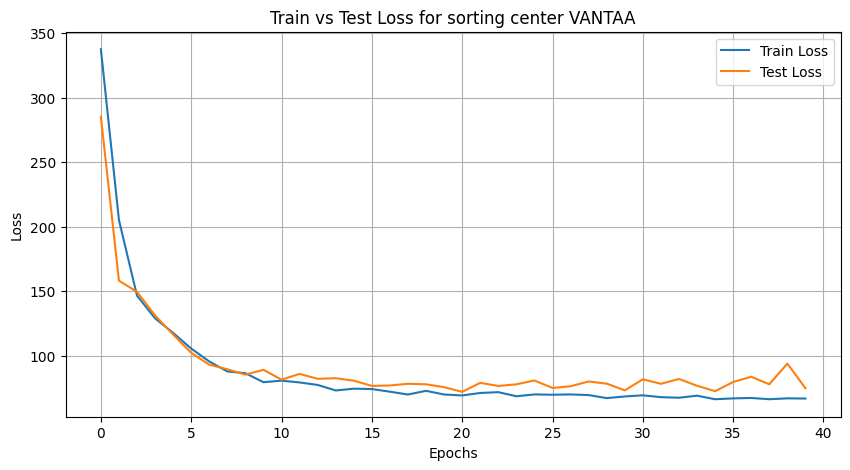

In [13]:
train_NN(df)

In [14]:
def generate_prediction_data(start_date, planning_horizon, df_sorting_center, output_belt):
    # Get unique output_belts and the index of the given output_belt for one-hot encoding
    output_belts = sorted(df_sorting_center["output_belt"].unique())
    belt_index = np.where(output_belts == output_belt)[0][0]
    
    # Initialize one-hot encoded array for output_belt
    one_hot_output_belt = np.zeros(len(output_belts))
    one_hot_output_belt[belt_index] = 1  # Set the corresponding position to 1

    x_data = []
    current_date = datetime.strptime(start_date, "%d-%m-%Y")
    end_date = current_date + timedelta(days=planning_horizon - 1)  # End date based on planning horizon
    
    while current_date <= end_date:
        day = current_date.day  # Dag van de maand
        weekday = current_date.isoweekday()  # Weekdag (1=maandag, 7=zondag)
        
        week_of_month = (current_date.day - 1) // 7 + 1
        
        # Calculate 'mult'
        mult = day * weekday * week_of_month
        
        # Concatenate one-hot output belt with other features into a single flat array
        x_data.append(np.concatenate((one_hot_output_belt, [day, weekday, week_of_month, mult])))
        current_date += timedelta(days=1)

    return np.array(x_data)

def forecast_NN(starting_date, planning_horizon, df):
    forecast_dict = {}
    sorting_center_names = df["sorting_center_name"].unique()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # paths
    save_dir_loaders = "Data/loaders NN/"
    save_dir_models = "Data/models NN/"    

    for sorting_center_name in sorting_center_names:
        # load loaders
        train_loader = torch.load(f"{save_dir_loaders}{sorting_center_name}_train_loader.pth")
        test_loader = torch.load(f"{save_dir_loaders}{sorting_center_name}_test_loader.pth")
        input_dim = next(iter(train_loader))[0].shape[1]

        # load model
        model = SimpleNN(input_dim)  # initialize the model architecture
        model.load_state_dict(torch.load(f"{save_dir_models}{sorting_center_name}_model.pth"))
        model.eval()

        df_sorting_center = df[df["sorting_center_name"] == sorting_center_name]
        output_belts = df_sorting_center["output_belt"].unique()

        for output_belt in output_belts:
            # Genereer predictie data
            x_data = generate_prediction_data(starting_date, planning_horizon, df_sorting_center, output_belt)
            x_tensor = torch.tensor(x_data).float().to(device)
            
            # Maak voorspellingen met het model
            with torch.no_grad():
                predictions = model(x_tensor).cpu().numpy().flatten()

            forecasts = pd.DataFrame(predictions)  # Convert Series to DataFrame
            forecasts.columns = ['forecasts']  # Rename the column to 'forecast

            # Round forecasts
            forecasts['forecasts'] = forecasts['forecasts'].round()

            if sorting_center_name == "VANTAA" and output_belt in [109]:
                plot_forecast(starting_date, planning_horizon, output_belt, forecasts, "NN")

            if sorting_center_name not in forecast_dict:
                forecast_dict[sorting_center_name] = {}

            forecast_dict[sorting_center_name][output_belt] = forecasts

    return forecast_dict

In [123]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*128)
        self.fc2 = nn.Linear(2*128, 2*128)
        self.fc3 = nn.Linear(2*128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        x1 = self.swish(self.fc1(x))
        x2 = self.swish(self.fc2(x1)) + x1  # Skip connection
        x3 = self.swish(self.fc3(x2))
        x4 = self.swish(self.fc4(x3)) + x3  # Skip connection
        x5 = self.swish(self.fc5(x4))
        output = self.fc6(x5)
        return output

In [ ]:
trained_models = {}
# criterion = nn.L1Loss()

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

class QuantileLoss(nn.Module):
    def __init__(self, tau):
        super(QuantileLoss, self).__init__()
        self.tau = tau
    
    def forward(self, outputs, targets):
        errors = targets - outputs
        loss = torch.max(self.tau * errors, (self.tau - 1) * errors)
        return loss.mean()
tau = 0.7  # Kies een waarde voor tau (0.5 is de mediaan)
criterion = QuantileLoss(tau=tau)

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=20, min_delta=0.1):
    train_losses, test_losses = [], []
    early_stopping_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _, _ in train_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_loss = 0.0
        total_mse = 0.0
        total_mae = 0.0
        with torch.no_grad():
            for inputs, targets, _, _ in test_loader:
                inputs, targets = inputs.float().to(device), targets.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                mse = nn.MSELoss()(outputs, targets)
                mae = nn.L1Loss()(outputs, targets)
                total_loss += loss.item()
                total_mse += mse.item()
                total_mae += mae.item()
        avg_test_loss = total_loss / len(test_loader)
        avg_test_mse = total_mse / len(test_loader)
        avg_test_mae = total_mae / len(test_loader)
        test_losses.append(avg_test_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
              f'MSE: {avg_test_mse:.4f}, MAE: {avg_test_mae:.4f}, LR: {current_lr:.6f}')
        
        # Early stopping op basis van de agressievere criteria
        if epoch >= patience:
            if avg_test_loss > min(test_losses[-patience:]) - min_delta:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0    
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break

    return train_losses, test_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for name, loader_dict in loaders.items():
    input_dim = next(iter(loader_dict['train_loader']))[0].shape[1]
    model = SimpleNN(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    
    print(f'Training model for {name}')
    train_losses, test_losses = train_model(
        model,
        loader_dict['train_loader'],
        loader_dict['test_loader'],
        criterion,
        optimizer,
        epochs=100,
        patience=20,
        min_delta=0.1
    )
    
    plot_losses(train_losses, test_losses)
    
    trained_models[name] = model


In [125]:
def plot_output_belts_for_center(model, test_loader, sorting_center_name, belts):
    all_outputs, all_targets, all_output_belts, all_yeardays = [], [], [], []

    for inputs, targets, output_belts, yearday in test_loader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        all_outputs.append(model(inputs).squeeze().cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        all_output_belts.append(output_belts.cpu().numpy())
        all_yeardays.append(yearday.cpu().numpy())

    all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, 
                                                                   (all_outputs, all_targets, all_output_belts, all_yeardays))

    for belt in belts:
        mask = all_output_belts == belt
        if mask.any():
            sort_idx = np.argsort(all_yeardays[mask])
            plt.figure(figsize=(15, 5))
            plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
            plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
            plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], 
                     label='Difference', linestyle='--', alpha=0.7)
            plt.xlabel('Yearday')
            plt.ylabel('Waarde')
            plt.title(f'Sorting Center: {sorting_center_name}, Output Belt {belt}')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"No data found for Output Belt {belt} in {sorting_center_name}")

def plot_for_all_centers(models, loaders, belts_per_center, specific_center=None, specific_belt=None, random_belts_count=5):
    for name, model in models.items():
        if specific_center and name != specific_center:
            continue  # Sla andere centers over als een specifiek center is opgegeven

        print(f"Plotting for Sorting Center: {name}")
        test_loader = loaders[name]['test_loader']
        
        # Controleer welke belts aanwezig zijn in de test_loader
        available_belts = set()
        for _, _, output_belts, _ in test_loader:
            available_belts.update(output_belts.cpu().numpy())
        print(f"Available belts in {name}: {sorted(available_belts)}")
        
        # Kies specifieke belt, anders willekeurige selectie
        if specific_belt:
            if specific_belt in available_belts:
                belts = [specific_belt]
            else:
                print(f"Specific belt {specific_belt} not found in {name}. Available belts are: {sorted(available_belts)}")
                continue
        else:
            belts = belts_per_center.get(name, [])
            if len(belts) > random_belts_count:
                belts = np.random.choice(belts, size=random_belts_count, replace=False)

        if len(belts) > 0:
            plot_output_belts_for_center(model, test_loader, name, belts)
        else:
            print(f"No belts defined for sorting center: {name}")

# Specificeer de belts voor elk center
belts_per_center = {}

for name in loaders:
    unique_belts = np.unique([belt for _, _, belts, _ in loaders[name]['test_loader'] for belt in belts.numpy()])
    belts_per_center[name] = unique_belts  # Bewaar alle unieke belts per center




In [ ]:
# Voorbeelden van gebruik:
# Specifiek plotten voor VANTAA en belt 109
plot_for_all_centers(trained_models, loaders, belts_per_center=belts_per_center, specific_center="VANTAA", specific_belt=109)

# Willekeurig 5 belts plotten voor elk center
plot_for_all_centers(trained_models, loaders, belts_per_center=belts_per_center, random_belts_count=5)


## Select en choose your sorting center, output belt, and days to predict

In [ ]:
input_tensor = torch.tensor(
([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  27,   5,   4, 540])
    ).float().to(device)  # Zet de tensor op het juiste device en datatype
input_tensor.shape
trained_models['VANTAA'](input_tensor)



# Multi warehouse model 

In [128]:
df = df_o

In [ ]:
df

In [ ]:
# Bewaar de originele output_belt kolom
df['old_output_belt'] = df['output_belt']

# Creëer een unieke ID op basis van de combinatie van sorting_center_name en output_belt
df['output_belt'] = (df['sorting_center_name'] + '_' + df['output_belt'].astype(str)).astype('category').cat.codes

def remove_sorting_centers(df, centers_to_remove):
    return df[~df['sorting_center_name'].isin(centers_to_remove)].reset_index(drop=True)

# Remove the 'VANTAA' sorting center
centers_to_remove = ['VANTAA']
df = remove_sorting_centers(df, centers_to_remove)

# Group the data by sorting center, scanning date, and output belt, then merge with other time-related columns
df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum() \
    .merge(df[['sorting_center_name', 'scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month', 'yearday']].drop_duplicates(), 
           on=['sorting_center_name', 'scanning_date'], how='left')

df

In [131]:
"Function to fill missing event data by generating all possible dates, sorting centers, and output belts, filling missing combinations with zero events."
def fill_missing_events(df):
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())
    all_combinations = []

    "Generate all combinations of sorting centers and output belts for all dates."
    for sorting_center in df['sorting_center_name'].unique():
        output_belts = df[df['sorting_center_name'] == sorting_center]['output_belt'].unique()
        combinations = pd.MultiIndex.from_product([[sorting_center], all_dates, output_belts], 
                                                  names=['sorting_center_name', 'scanning_date', 'output_belt'])
        all_combinations.append(pd.DataFrame(index=combinations).reset_index())  

    "Merge generated combinations with original data, filling missing events with 0."
    all_combinations_df = pd.concat(all_combinations, ignore_index=True)
    df_filled = pd.merge(all_combinations_df, df, on=['sorting_center_name', 'scanning_date', 'output_belt'], how='left')
    
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)  
    "Add time-related features to enhance dataset information."
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1
    df_filled['yearday'] = df_filled['scanning_date'].dt.dayofyear  

    return df_filled

df = fill_missing_events(df)

In [132]:
"Sort data chronologically and reset the index to maintain order."
df = df.sort_values(by='scanning_date')
df = df.reset_index(drop=True)

In [ ]:
"Create new columns 'mult' and 'sum' to capture relationships between day, weekday, and week_of_month."
df['mult'] = df['day'] * df['weekday'] * df['week_of_month']
df['sum'] = df['day'] + df['weekday'] + df['week_of_month']
    
# Maak one-hot encoded kolommen zonder de originele 'output_belt' kolom te verwijderen
one_hot_belt = pd.get_dummies(df['output_belt'], prefix='output_belt').astype(int)
df = pd.concat([df, one_hot_belt], axis=1)
df

In [134]:
"Define a dataset class for structured use in PyTorch."
class EventDataset(Dataset):
    def __init__(self, df):

        self.data = df  
        one_hot_columns = [col for col in self.data.columns if col.startswith('output_belt_')]
        feature_columns = one_hot_columns + ['day', 'weekday', 'week_of_month', 'mult']
        self.inputs = torch.tensor(self.data[feature_columns].values.astype(int), dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
"Create dataloaders for train and test datasets with specified batch size and split method."
def create_dataloaders_for_df(df, test_size=0.25, batch_size=512, method='sequential'):
    train_df, test_df = split_dataset(df, method=method, test_size=test_size)
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

"Function to split the dataset either sequentially or randomly based on the chosen method."
def split_dataset(df, method='sequential', test_size=0.25):
    if method == 'random':
        return train_test_split(df, test_size=test_size, random_state=42)
    else:  
        split_idx = int((1 - test_size) * len(df))
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        return train_df, test_df


"Initialize train and test loaders using the split dataset."
train_df, test_df = split_dataset(df, test_size=0.25, method='sequential')

train_loader = DataLoader(EventDataset(train_df), batch_size=512, shuffle=False)
test_loader = DataLoader(EventDataset(test_df), batch_size=512, shuffle=True)

train_inputs, train_targets, _, _ = next(iter(train_loader))
test_inputs, test_targets, _, _ = next(iter(test_loader))

"Print sample input and target data for verification."
print(f"Train Input: {train_inputs[0]}, Train Target: {train_targets[0].item()}")
print(f"Test Input: {test_inputs[0]}, Test Target: {test_targets[0].item()}\n")

In [ ]:
"Define a simple neural network model with skip connections for enhanced representation learning."
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*128)
        self.fc2 = nn.Linear(2*128, 2*128)
        self.fc3 = nn.Linear(2*128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        x1 = self.swish(self.fc1(x))
        x2 = self.swish(self.fc2(x1)) + x1  
        x3 = self.swish(self.fc3(x2))
        x4 = self.swish(self.fc4(x3)) + x3  
        x5 = self.swish(self.fc5(x4))
        output = self.fc6(x5)
        return output

"Determine input dimensions based on training data and initialize the model and optimizer."
input_dim = next(iter(train_loader))[0].shape[1]  
model = SimpleNN(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

"Train the model and capture train and test losses for tracking model performance."
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=20, min_delta=0.1)

"Plot the train and test losses for visualizing training progress."
plot_losses(train_losses, test_losses)

"Select unique belts for plotting output belt predictions on a single sorting center."
unique_belts = np.unique([belt for _, _, belts, _ in test_loader for belt in belts.numpy()])
selected_belts = np.random.choice(unique_belts, size=min(10, len(unique_belts)), replace=False)

"Plot prediction results for a specific sorting center using the selected output belts."
plot_output_belts_for_center(model, test_loader, "Sorting Center 1", selected_belts)



In [ ]:
planning_horizon = 14

train_df = df[df["month"] <= 9] # Train on first 9 months
test_df = df[(df["month"] == 10) & (df["day"] <= planning_horizon)] # Test on first two weeks of 10th month

starting_date = test_df.iloc[0]["scanning_date"]

train_NN(train_df, test_df, planning_horizon)

#### Rural vs capital
Model for rural sorting centers together

In [ ]:
belts_per_center = {}

for name in loaders:
    unique_belts = np.unique([belt for _, _, belts, _ in loaders[name]['test_loader'] for belt in belts.numpy()])
    belts_per_center[name] = np.random.choice(unique_belts, size=3, replace=False)

def plot_for_all_centers(models, loaders, belts_per_center):
    for name, model in models.items():
        print(f"Plotting for Sorting Center: {name}")
        test_loader = loaders[name]['test_loader']

        belts = belts_per_center.get(name, [])
        if belts.size > 0:  # Pas deze regel aan
            plot_output_belts_for_center(model, test_loader, name, belts)

plot_for_all_centers(trained_models, loaders, belts_per_center=belts_per_center)

### ARIMA

#### Hyperparameter tuning
We need to develop a model for each output belt at every sorting center. To ensure the accuracy of our models, we will train the hyperparameters p, d an q using data from the first nine months. These hyperparameters will be saved for future forecasts.

In the context of ARIMA:
- p represents the number of lag observations included in the model (the autoregressive term).
- d denotes the degree of differencing needed to make the time series stationary.
- q indicates the size of the moving average window, which reflects the number of lagged forecast errors in the prediction equation.

In [15]:
def tune_hyperparameters(df_output_belt):
    # Perform Box-Cox transformation to fasten the process
    df_output_belt["no_of_events_boxcox"], lam = boxcox(df_output_belt["no_of_events"])
    df_output_belt["no_of_events_diff"] = df_output_belt["no_of_events_boxcox"].diff()
    df_output_belt.dropna(inplace=True)

    # Tune the model
    tuning_model = auto_arima(df_output_belt["no_of_events_boxcox"], 
                               seasonal=False, 
                               stepwise=True,  
                               suppress_warnings=True, 
                               trace=False)

    
    p, d, q = tuning_model.order
    return (df_output_belt["output_belt"].iloc[0], p, d, q)

def train_ARIMA(df):
    sorting_center_names = df["sorting_center_name"].unique()

    for sorting_center_name in sorting_center_names:
        df_sorting_center = df[df["sorting_center_name"] == sorting_center_name]
        df_sorting_center.drop(["sorting_center_name"], axis=1, inplace=True)
        
        hyperparameterList = []
        output_belts = df_sorting_center["output_belt"].unique()

        results = Parallel(n_jobs=-1)(delayed(tune_hyperparameters)(
            df_sorting_center[df_sorting_center["output_belt"] == output_belt]) 
            for output_belt in output_belts)
        
        hyperparameterList.extend(results)

        hyperparameter_df = pd.DataFrame(hyperparameterList, columns=["output belt", "p", "d", "q"])
        hyperparameter_df.to_csv(f'Data/hyperparameters ARIMA/hyperparameters_ARIMA_{sorting_center_name}.csv', index=False)

#### Forecast ARIMA model

In [16]:
# Test ARIMA per output belt
def forecast_ARIMA(starting_date, planning_horizon, train_df, test_df = pd.DataFrame([]), start = datetime.now()):
    sorting_center_names = df["sorting_center_name"].unique()

    forecast_dict = {}
    if test_df.shape[0] > 0:
        daily_errors = {}
        MSE_dict = {}
        VSE_dict = {}
        MAE_dict = {}

    for sorting_center_name in sorting_center_names:
        hyperparameters = pd.read_csv("Data/hyperparameters ARIMA/hyperparameters_ARIMA_{}.csv".format(sorting_center_name))

        train_sorting_center = train_df[train_df["sorting_center_name"] == sorting_center_name]

        if test_df.shape[0] > 0:
            test_sorting_center = test_df[test_df["sorting_center_name"] == sorting_center_name]

        output_belts = train_sorting_center['output_belt'].unique()

        for output_belt in output_belts:
            train_output_belt = train_sorting_center[train_sorting_center["output_belt"] == output_belt]

            if test_df.shape[0] == 0:
                test_output_belt = pd.Dataframe([])
            elif test_df.shape[0] > 0:
                test_output_belt = test_sorting_center[test_sorting_center["output_belt"] == output_belt]

            p, d, q = hyperparameters[hyperparameters.iloc[:, 0] == output_belt].iloc[0, 1:4]

            arima_model = ARIMA(train_output_belt["no_of_events"], order=(p, d, q)).fit()

            # Forecast for the planning horizon
            forecasts = arima_model.forecast(steps=planning_horizon)

            # Assuming `predictions` is your Series with the forecast values
            forecasts = pd.DataFrame(forecasts)  # Convert Series to DataFrame
            forecasts.columns = ['forecasts']  # Rename the column to 'forecast

            if sorting_center_name == "VANTAA" and output_belt in [66, 109, 333]:
                plot_forecast(starting_date, planning_horizon, output_belt, forecasts, "ARIMA", train_output_belt, test_output_belt)

            if test_df.shape[0] == 0: 
                if sorting_center_name not in forecast_dict:
                    forecast_dict[sorting_center_name] = {}
                
                forecast_dict[sorting_center_name][output_belt] = forecasts
                
            elif test_df.shape[0] > 0: 
                for day in range(planning_horizon):
                    actual = test_output_belt.iloc[day]["no_of_events"]
                    forecast = forecasts.iloc[day]

                    squared_difference = (actual - forecast) ** 2
                    absolute_difference = abs(actual - forecast)

                    if sorting_center_name not in daily_errors:
                        daily_errors[sorting_center_name] = {}
                    if day not in daily_errors[sorting_center_name]:
                        daily_errors[sorting_center_name][day] = {}
                        daily_errors[sorting_center_name][day]["mse"] = []
                        daily_errors[sorting_center_name][day]["mae"] = []
                    
                    daily_errors[sorting_center_name][day]["mse"].append(squared_difference)
                    daily_errors[sorting_center_name][day]["mae"].append(absolute_difference)

    if test_df.shape[0] > 0: 
        for sorting_center_name in sorting_center_names:
            mse = {}
            mae = {}
            for day in range(planning_horizon):
                mse[day] = sum(daily_errors[sorting_center_name][day]["mse"]) / len(daily_errors[sorting_center_name][day]["mse"])
                mae[day] = sum(daily_errors[sorting_center_name][day]["mae"]) / len(daily_errors[sorting_center_name][day]["mae"])

            MSE_dict[sorting_center_name] = sum(mse.values()) / len(mse)
            VSE_dict[sorting_center_name] = np.var(list(mse.values()), ddof=1)
            MAE_dict[sorting_center_name] = sum(mae.values()) / len(mae)

        daily_mse = {}
        daily_mae = {}

        for day in range(planning_horizon):
            mse = 0
            mae = 0
            n_output_belts = 0
            for sorting_center_name in sorting_center_names:
                mse += sum(daily_errors[sorting_center_name][day]["mse"])
                mae += sum(daily_errors[sorting_center_name][day]["mae"])
                n_output_belts += len(daily_errors[sorting_center_name][day]["mse"])
            daily_mse[day] = mse / n_output_belts
            daily_mae[day] = mae / n_output_belts

        MSE_dict["total"] = sum(daily_mse.values()) / len(daily_mse)
        VSE_dict["total"] = np.var(list(daily_mse.values()), ddof=1)
        MAE_dict["total"] = sum(daily_mae.values()) / len(daily_mae)

        with open("Results/results_ARIMA.csv", mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Sorting center', 'MSE', 'VSE', 'MAE'])
            
            for key in MSE_dict.keys():
                # Extract the first value from each Series
                mse_value = MSE_dict[key].values[0] if isinstance(MSE_dict[key], pd.Series) else MSE_dict[key]
                vse_value = VSE_dict[key].values[0] if isinstance(VSE_dict[key], pd.Series) else VSE_dict[key]
                mae_value = MAE_dict[key].values[0] if isinstance(MAE_dict[key], pd.Series) else MAE_dict[key]
                
                writer.writerow([key, mse_value, vse_value, mae_value])

        with open("Results/results_general.csv", mode='a', newline='') as file:
            writer = csv.writer(file)

            end = datetime.now()

            mse_value = MSE_dict["total"].values[0] if isinstance(MSE_dict["total"], pd.Series) else MSE_dict["total"]
            vse_value = VSE_dict["total"].values[0] if isinstance(VSE_dict["total"], pd.Series) else VSE_dict["total"]
            mae_value = MAE_dict["total"].values[0] if isinstance(MAE_dict["total"], pd.Series) else MAE_dict["total"]
            running_time = end - start

            writer.writerow(['ARIMA', mse_value, vse_value, mae_value, running_time, "-"])

    return forecast_dict

### Predictions ARIMA model
Make forecasts for all sorting centers and report the important KPIs to evaluate the performance. These are the mean squared error (MSE), variance squared error (VSE) and mean absolute error (MAE)

In [17]:
df_ARIMA = df.copy()

planning_horizon = 14

train = df[df["month"] <= 9] # Train on first 9 months
test = df[(df["month"] == 10) & (df["day"] <= planning_horizon)] # Test on first two weeks of 10th month

starting_date = "01-10-2023"

start = datetime.now()
#train_ARIMA(train)
forecast_ARIMA(starting_date, planning_horizon, train, test, start)

end = datetime.now()
print("Running time training ARIMA is: " + str(end-start))

c:\Users\tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is availab

KeyboardInterrupt: 

## LSTM/GRU

Because of the sparse data, engineering features to improve the model on can pose a challenge. For this reason, a new method was proposed using wave decomposition. One of the ways to do this, is through CEEMDAN.

#### CEEMDAN

CEEMDAN, or Complete Ensemble Empirical Mode Decomposition with Adaptive Noise, is a signal processing technique used to analyze non-linear and non-stationary time series data. It decomposes a signal into components known as Intrinsic Mode Functions (IMFs), which can then be used as features to train various types of Recurrent Neural Networks (RNNs), such as LSTM and GRU.

CEEMDAN combines two key techniques:
- Empirical Mode Decomposition (EMD): Breaks down signals into IMFs without assuming linearity or stationarity.
- Ensemble Empirical Mode Decomposition (EEMD): Improves EMD by adding white noise to the signal to reduce mode mixing.

By adding adaptive noise and white noise, CEEMDAN extracts purer frequencies from the signal, enhancing the precision and robustness of the decomposition.

This technique shows promise for our goals of feature extraction from limited data. By decomposing the signal, we can detect patterns like seasonality and outliers directly from the data itself, without relying on biased inputs. Since CEEMDAN is often used in forecasting unpredictable time series, such as weather, wind speeds, and stock markets, we are exploring its potential for improving package prediction in our system.

There are multiple methods of deploying the IMF's as vector/matrix inputs:

| Forecast Method     | Description                                                                                      |
|---------------------|--------------------------------------------------------------------------------------------------|
| Single Method       | Use Keras model to directly forecast with vector input                                           |
| Ensemble Method     | Use decomposition-integration Keras model to directly forecast with matrix input                 |
| Respective Method   | Use decomposition-integration Keras model to respectively forecast each IMF with vector input    |
| Hybrid Method       | Use the ensemble method to forecast high-frequency IMF and the respective method for other IMFs. |
| Multiple Method     | Multiple runs of the above method                                                                |
| Rolling Method      | Rolling run of the above method to avoid the look-ahead bias, but takes a long time              |

The data being used is aggregated, because the method decomposes the signal into multiple Intrinsic Mode Functions (IMFs). The model will than be trained on each IMF. This results in long computation times for making predictions —about two minutes for GRU and LSTM models, even with plotting functions disabled. Applying this approach to each output belt is not feasible. Later, we will try to use a similar method but we will be employing parralel computing to decrease the computation times.

In [ ]:
# Aggregating data
adf = df.groupby(['scanning_date', 'sorting_center_name'])['no_of_events'].sum().reset_index()

# Extracting day, month, weekday, week, and yearday features
adf['day'] = adf['scanning_date'].dt.day
adf['month'] = adf['scanning_date'].dt.month
adf['weekday'] = adf['scanning_date'].dt.day_of_week + 1
adf['week'] = adf['scanning_date'].dt.day_of_year // 7 + 1
adf['yearday'] = adf['scanning_date'].dt.day_of_year

# Adding sinusoidal and cosinusoidal transformations for yearday
adf['yearday_sin'] = np.sin(adf['yearday'] / 7 * 2 * np.pi)
adf['yearday_cos'] = np.cos(adf['yearday'] / 7 * 2 * np.pi)

# Filtering data for 'VANTAA' sorting center and setting the index
data = adf[adf['sorting_center_name'] == 'VANTAA'].set_index('scanning_date')
data = data['no_of_events']

In [ ]:
# LSTM, 14 days prediction
cl.statis_tests(data)
kr = cl.keras_predictor(
    FORECAST_HORIZONS=14,
    FORECAST_LENGTH=14,
    KERAS_MODEL='LSTM',
    DECOM_MODE='CEEMDAN',
    DAY_AHEAD=1,
    NOR_METHOD='minmax',
    FIT_METHOD='add',
    REDECOM_LIST={'co-imf0': 'ovmd'}
)
df_result = kr.hybrid_keras_predict(data=data, show=True, plot=True, save=True)


In [ ]:
# GRU model, 14 days prediction using CEEMDAN decomposition and min-max normalization
# Assumes 'cl' is a class instance with statistical testing and prediction methods

# Perform statistical tests on the data
cl.statis_tests(data)

# Initialize the keras predictor with specified parameters
kr = cl.keras_predictor(
    FORECAST_HORIZONS=14,
    FORECAST_LENGTH=14,
    KERAS_MODEL='GRU',
    DECOM_MODE='CEEMDAN',
    DAY_AHEAD=1,
    NOR_METHOD='minmax',
    FIT_METHOD='add',
    REDECOM_LIST={'co-imf0': 'ovmd'}
)

# Run the hybrid Keras prediction and store the results in df_result
df_result = kr.hybrid_keras_predict(data=data, show=True, plot=True, save=True)

#### Parralel computing

We were inspired by the success of CEEMDAN (Complete Ensemble Empirical Mode Decomposition with Adaptive Noise) in improving clustering models. However, while CEEMDAN is well-suited for aggregated time-series analysis, it lacks the granularity required for predicting outputs at the level of each output belt within each sorting center. Therefore, we adapted its core decomposition philosophy to suit our specific needs, allowing us to improve the computational efficiency by enabling parallel processing across belts. This adaptation not only drew upon the strength of CEEMDAN in decomposing non-stationary signals but also introduced modifications that better accommodate the unique characteristics of our problem—specifically the need to process data for multiple output belts concurrently. Our approach ensures each output belt can be analyzed individually while maintaining computational efficiency.

To address the challenge of predicting sparse time-series data in this project, we designed a predictive approach combining GRU and signal decomposition techniques. The objective of the project is to predict event counts for different conveyor belts at each sorting center. Due to data sparsity and the presence of outliers, traditional time-series methods struggle to effectively model the behavior. In this context, we chose the GRU (Gated Recurrent Unit) model as it effectively captures both short- and long-term dependencies with fewer parameters, making it more suitable for training on sparse data compared to more complex LSTM models, which may be prone to overfitting in this scenario. To enhance the model's generalization ability and extract latent patterns from the data, we applied signal decomposition techniques—using both wavelet transform and Empirical Mode Decomposition (EMD). This was done to provide clearer learning inputs for the GRU, enhancing its ability to handle the peculiarities of the dataset.

In the signal processing step, the wavelet transform was utilized to decompose each conveyor belt's signal into different frequency components, thereby extracting richer information in both time and frequency domains. Empirical Mode Decomposition (EMD) was used to decompose the signal into intrinsic mode functions (IMFs), making it particularly effective at capturing nonlinear and non-stationary signal characteristics. By employing this hybrid signal decomposition strategy, the model can avoid being misled by outliers within the sparse data, extracting the most useful features for predicting event counts. We also employed data augmentation techniques by adding random shifts and introducing synthetic outliers to increase data volume, thereby enhancing the robustness and generalizability of the model. In the final setup, each sorting center's conveyor belts were modeled individually, ensuring the accuracy of the prediction to align with the unique dynamic patterns of each belt.

To effectively train these models, we employed a strategy combining GRU with specific optimization techniques. The optimization process leveraged Stochastic Gradient Descent (SGD) with momentum, which helps accelerate convergence and reduce the influence of outliers during training. Learning rates were dynamically adjusted using a cosine annealing scheduler to ensure that the model finds a global optimum effectively during the latter part of training. For each sorting center's conveyor belts, we independently calculated the Mean Squared Error (MSE) and Variance of Squared Error (VSE) to assess the model's overall performance and its consistency across different time periods. With this comprehensive approach, we successfully developed custom predictive models for each sorting center, effectively addressing the challenges posed by the sparse data and achieving accurate event count predictions for each output belt.

Despite this, there remain some challenges due to the inherent sparsity of the data and limitations in sampling duration. The average data volume per conveyor belt within each sorting center is relatively low, which makes it difficult for the model to capture complex dynamic features. Furthermore, the current dataset only spans one year, making it challenging to effectively capture seasonality and other cyclical patterns. Thus, while this model utilizes a variety of signal processing and optimization techniques, its predictive performance may be somewhat limited by the available data. This suggests that future improvements—such as expanding data volume and gathering multi-year data—could significantly enhance model performance.

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

# Define hyperparameters
sequence_length = 15
hidden_channels = 16
batch_size = 256
num_epochs = 20
learning_rate = 0.001
weight_decay = 1e-4
momentum = 0.9
dropout_rate = 0.3

# Create GRU input sequences
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        Y.append(data[i + sequence_length])
    return np.array(X), np.array(Y)

# Wavelet-based decomposition function (GPU-friendly)
def decompose_signal_wavelet(signal, wavelets=['db1', 'haar', 'sym5'], level=None):
    if level is None:
        level = min(1, int(np.log2(len(signal))))  # Dynamic level selection
    coeffs_list = []
    for wavelet in wavelets:
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
        coeffs = [torch.tensor(c, dtype=torch.float32).to(device) for c in coeffs]
        coeffs_list.extend(coeffs)
    return coeffs_list

# Empirical Mode Decomposition (EMD) based decomposition
def decompose_signal_emd(signal):
    emd = EMD()  # Initialize EMD class
    imfs = emd.emd(signal)  # Perform EMD decomposition
    imfs = [torch.tensor(imf, dtype=torch.float32).to(device) for imf in imfs]
    return imfs

# GRU model for time series
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Data augmentation for sparse data
def augment_data(signal, num_augments=10, noise_level=0.02):
    augmented_signals = [signal]
    for _ in range(num_augments):
        noise = noise_level * np.random.randn(len(signal))
        shifted_signal = np.roll(signal, shift=np.random.randint(-5, 5))
        augmented_signal = shifted_signal + noise
        augmented_signals.append(augmented_signal)
    return np.array(augmented_signals)

# Load and preprocess dataset
'''df['scanning_date'] = pd.to_datetime(df['scanning_date'])
df = df.sort_values(by='scanning_date').reset_index(drop=True)

# Train/Test split
train_size = int(0.75 * len(df))
test_size = int(0.05 * len(df))
train_df = df[:train_size]
test_df = df[train_size:train_size + test_size]

# Data preprocessing
feature_columns = ['day', 'month', 'weekday', 'week', 'yearday_sin', 'yearday_cos']

# Fill missing values with median values for robustness
train_df = train_df.copy()
test_df = test_df.copy()

train_df[feature_columns] = train_df[feature_columns].fillna(train_df[feature_columns].median(numeric_only=True))
test_df[feature_columns] = test_df[feature_columns].fillna(test_df[feature_columns].median(numeric_only=True))'''



In [ ]:
df_GRU = df.copy()

planning_horizon = 14
starting_date = "01-10-2023"

train_df = df_GRU[df_GRU["month"] <= 9]
test_df = df_GRU[(df_GRU["month"] == 10) & (df_GRU["day"] <= planning_horizon)]

# Data preprocessing
feature_columns = ['day', 'month', 'weekday', 'week', 'yearday_sin', 'yearday_cos']

# Fit scalers with valid data only
scaler_features = RobustScaler()
train_features = scaler_features.fit_transform(train_df[feature_columns])
test_features = scaler_features.transform(test_df[feature_columns])

scaler_target = StandardScaler()
train_targets = scaler_target.fit_transform(train_df['no_of_events'].values.reshape(-1, 1))
test_targets = scaler_target.transform(test_df['no_of_events'].values.reshape(-1, 1))

# Decompose each output belt's signal using Wavelet and EMD-based method
output_belt_ids = train_df['output_belt'].unique()
imfs_dict = {}
for belt in output_belt_ids:
    belt_signal = train_df[train_df['output_belt'] == belt]['no_of_events'].values
    if len(belt_signal) == 0:
        continue
    augmented_signals = augment_data(belt_signal)
    imfs = []
    for augmented_signal in augmented_signals:
        # Apply both Wavelet and EMD decomposition
        wavelet_coeffs = decompose_signal_wavelet(augmented_signal)
        emd_imfs = decompose_signal_emd(augmented_signal)
        imfs.extend(wavelet_coeffs)
        imfs.extend(emd_imfs)
    imfs_dict[belt] = imfs

# Assign sorting centers to belts and create models for each sorting center
sorting_center_models = {}
sorting_center_belts = train_df.groupby('sorting_center_name')['output_belt'].unique().to_dict()

# Create GRU models for each sorting center
for sorting_center, belts in sorting_center_belts.items():
    if sorting_center not in sorting_center_models:
        model = GRUModel(input_size=1, hidden_size=hidden_channels, num_layers=2, output_size=1, dropout_rate=dropout_rate).to(device)
        sorting_center_models[sorting_center] = model

# Training loop for each sorting center model
belt_predictions_actuals = {}
for sorting_center, belts in sorting_center_belts.items():
    model = sorting_center_models[sorting_center]
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    all_X_train, all_Y_train = [], []
    belt_losses = {}
    for belt in belts:
        imfs = imfs_dict.get(belt, [])
        belt_losses[belt] = []  # Ensure initialization of belt_losses before using it
        for imf in imfs:
            X_train, Y_train = create_sequences(imf.cpu().numpy(), sequence_length=sequence_length)
            if len(X_train) > 0:
                all_X_train.append(X_train)
                all_Y_train.append(Y_train)

    if len(all_X_train) > 0:
        X_train_tensor = torch.tensor(np.concatenate(all_X_train), dtype=torch.float32).unsqueeze(2)
        Y_train_tensor = torch.tensor(np.concatenate(all_Y_train), dtype=torch.float32).unsqueeze(1)
        train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch_X, batch_Y in train_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = nn.MSELoss()(outputs.view(-1), batch_Y.view(-1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                running_loss += loss.item()

            # Step scheduler
            scheduler.step()

            print(f"Sorting Center: {sorting_center}, Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Store predictions and actuals for each belt
        model.eval()
        with torch.no_grad():
            for belt in belts:
                imfs = imfs_dict.get(belt, [])
                belt_predictions = []
                belt_actuals = []

                for imf in imfs:
                    X_test, Y_test = create_sequences(imf.cpu().numpy(), sequence_length=sequence_length)
                    if len(X_test) > 0:
                        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2).to(device)
                        Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

                        predictions = model(X_test_tensor).cpu().numpy().flatten()
                        actuals = Y_test_tensor.cpu().numpy().flatten()

                        belt_predictions.extend(predictions)
                        belt_actuals.extend(actuals)

                # Store for KPI calculation
                belt_predictions_actuals[belt] = {'predictions': belt_predictions, 'actuals': belt_actuals}

# Calculate KPIs for each sorting center
sorting_center_metrics = {}
for sorting_center, belts in sorting_center_belts.items():
    daily_errors = {}
    for belt in belts:
        if belt not in belt_predictions_actuals:
            continue
        predictions = belt_predictions_actuals[belt]['predictions']
        actuals = belt_predictions_actuals[belt]['actuals']
        scanning_dates = test_df['scanning_date'][sequence_length:sequence_length + len(predictions)]

        # Calculate squared deviation for each day
        for date, actual, predicted in zip(scanning_dates, actuals, predictions):
            daily_errors.setdefault(date, []).append((actual - predicted) ** 2)

    # Calculate overall KPI for sorting center
    daily_rmse = {date: np.sqrt(np.mean(errors)) for date, errors in daily_errors.items()}
    sorting_center_metrics[sorting_center] = {'daily_rmse': daily_rmse, 'mean_rmse': np.mean(list(daily_rmse.values()))}

print(sorting_center_metrics)

# Results

Comparison table with all benchmarks.

## Conclusion
Write about pro and cons

In [ ]:
# Conclusion

## Dashboard forecast (Tom)
Standardize input + output
Make accessible for forecast

In [ ]:
# Make the training functions for all models such that the training can be saved and used for prediction every time when needed

def train_model(data, model):
    data = prepare_data(data) # Ensure that data is ready for training

    if model == "Linear Regression":
        # Linear Regression model does not need to be trained
        print("Training is finished")
    elif model == "ARIMA":
        train_ARIMA(data)
        print("Training is finished")
    elif model == "Neural Network":
        train_NN(data)
        print("Training is finished")

In [ ]:
def make_forecast(start_date, planning_horizon, data, model):
    if model == "Linear Regression":
        forecast = forecast_LR(start_date, planning_horizon, data)        
        print("Forecast finished")
    elif model == "ARIMA":
        forecast = forecast_ARIMA(start_date, planning_horizon, data)
        print("Forecast finished")
    elif model == "Neural Network":
        forecast = forecast_NN(start_date, planning_horizon, data)
        print("Forecast finished")
        
    return forecast

In [ ]:
def save_forecast(start_date, planning_horizon, model, forecast):
    for sorting_center_name, output_belts in forecast.items():
        # Define the file name
        file_name = f"Results/forecast_{model}_{sorting_center_name}.csv"
        
        # Open the file for writing
        with open(file_name, mode='w', newline='') as file:
            writer = csv.writer(file)
            
            # Construct the list of dates for the forecast period
            dates = [(start_date + timedelta(days=day)).strftime("%Y-%m-%d") for day in range(planning_horizon)]
            
            # Write the header row (Dates)
            header = ['Output Belt'] + dates
            writer.writerow(header)
            
            # Write the forecast data
            for output_belt, forecasts in output_belts.items():
                row = [output_belt] + forecasts.tolist()  # Convert forecasts to list if it's a NumPy array
                writer.writerow(row)
    
    print("Forecasts successfully written to CSV files.")


In [ ]:
def main(start_date, planning_horizon, data, model, train_indicator = False):
    if train_indicator == True:
        train_model(data, model)

    start = datetime.now()
    forecast = make_forecast(start_date, planning_horizon, data, model)
    end = datetime.now()
    save_forecast(start_date, planning_horizon, forecast)

In [ ]:
# Main
directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"
df = pd.read_csv(directory_path)

# Input
start_date = "01-10-2023"       # When does the planning horizon start
planning_horizon = 14           # How long is the planning horizon
data = df[df["month"] <= 9]     # Always needed since some models need it for prediction
model = "ARIMA"                 # Which model do you want to use, options are Linear Regression, ARIMA and Neural Network 
train_indicator = False         # Optional, if you want to train the model

main(start_date, planning_horizon, data, model)